In [268]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [269]:
query =\
'''
-- query for clustering v2
WITH users AS (
  SELECT DISTINCT user_id
  FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
  WHERE last_transaction_date >= '2023-04-01'
)

, loyalty AS (
  SELECT 
    user_id, 
    date_,
    kyc_tier,
    loyalty_tier,
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE 
    date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
    AND kyc_tier <> 'NON_KYC'
)

, campaigns AS (
  SELECT
    user_id,
    DATE_ADD(DATE_TRUNC(date_, MONTH), INTERVAL 1 MONTH) AS date_,
    SUM(daily_OTHER_saldo) AS M1_campaign_saldo
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE date_ BETWEEN '2023-04-01' AND '2023-07-31'
  GROUP BY 1, 2
)


, payments AS (
  SELECT
    user_id,
    DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
    -- TRANSACTIONS
    COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS M1_core_count,
    COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS M1_ppob_count,
    -- CUSTOMER
    COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS total_customer,
  FROM `ledger-fcc1e.payment_reports.payments_ssot`
  WHERE
    status_v2 = 'COMPLETED'
    AND transaction_date BETWEEN '2023-04-01' AND '2023-07-31'
  GROUP BY 1, 2
)

, accountings AS (
  SELECT DISTINCT
    DATE_ADD(DATE_TRUNC(DATE(trans_createdAt), MONTH), INTERVAL 1 MONTH) AS date_,
    createdByUser AS user_id,
    COUNT(DISTINCT transactionId) AS M1_acc_count
  FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
  WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
  GROUP BY 1, 2
)

-- //this is a bit inefficient since i load the same table twice...
-- //open to idea on how to do it better
-- , banks AS (
--   SELECT DISTINCT
--     user_id,
--     date_,
--     ARRAY_AGG(money_in_channel) OVER(PARTITION BY user_id, date_ ORDER BY cnt_ DESC) [OFFSET(0)] AS main_funding_bank
--   FROM (
--     SELECT 
--       user_id,
--       DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
--       money_in_channel,
--       COUNT(*) AS cnt_
--     FROM `ledger-fcc1e.payment_reports.payments_ssot`
--     WHERE
--       status_v2 = 'COMPLETED'
--       AND product_type IN ('SALDO')
--       AND transaction_date BETWEEN '2023-04-01' AND '2023-07-01'
--     GROUP BY 1, 2, 3
--   )
-- )

, referrals AS (
  SELECT 
    referrer AS user_id,
    date_,
    COUNT(DISTINCT referee) AS referee_count
  FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
  WHERE date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
  GROUP BY 1, 2
)

, profiles AS (
  SELECT DISTINCT
    user_id,
    acquisition_channel,
    user_segment_sub_bucket,
    first_user_date,
    first_any_payment_date,
    first_transaction_date
  FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
)

, impressions AS (
  SELECT
    SUBSTR(phone_number, 4) AS user_id,
    DATE_ADD(DATE_TRUNC(notification_date, MONTH), INTERVAL 1 MONTH) AS date_,
    SUM(pn_count) AS send_count,
    SUM(impressions_count) AS impressions_count,
    SUM(read_count) AS read_count,
    COUNT(DISTINCT user_activated) AS activated_count,
    COUNT(DISTINCT user_converted) AS converted_count
  FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
  WHERE 
    notification_date BETWEEN '2023-04-01' AND '2023-08-31'
    AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
  GROUP BY 1, 2
)

SELECT DISTINCT
  user_id,
  date_,
  kyc_tier,
  loyalty_tier,
  (CASE WHEN M1_core_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_core_count END) AS M1_core_count,
  (CASE WHEN M1_ppob_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_ppob_count END) AS M1_ppob_count,
  (CASE WHEN M1_acc_count IS NULL AND date_ >= first_transaction_date THEN 0 ELSE M1_acc_count END) AS M1_acc_count,
  M1_campaign_saldo,
  -- (CASE WHEN M1_core_count > 0 THEN 1 ELSE M1_core_count END) AS M1_core_count,
  -- (CASE WHEN M1_ppob_count > 0 THEN 1 ELSE M1_ppob_count END) AS M1_ppob_count,
  -- (CASE WHEN M1_acc_count > 0 THEN 1 ELSE M1_acc_count END) AS M1_acc_count,
  -- (CASE WHEN M1_campaign_saldo > 0 THEN 1 ELSE M1_campaign_saldo END) AS M1_campaign_saldo,
  total_customer,
  -- IFNULL(
  --   IFNULL(
  --     LAST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
  --     FIRST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
  --   ),
  --   NULL
  -- ) AS main_funding_bank,
  (CASE WHEN referee_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
  acquisition_channel,
  user_segment_sub_bucket,
  DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
  CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
  CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
  CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
  IFNULL(activated_count, 0) AS is_act_m1,
  IFNULL(converted_count, 0) AS is_conv_m1
FROM users -- active in last 12 months
INNER JOIN loyalty USING (user_id) -- needs to be atleast KYC
LEFT JOIN payments USING (user_id, date_) -- get Q2 transaction data
-- LEFT JOIN banks USING (user_id, date_)
LEFT JOIN referrals USING (user_id, date_)
LEFT JOIN impressions USING (user_id, date_)
LEFT JOIN accountings USING (user_id, date_)
LEFT JOIN campaigns USING (user_id, date_)
LEFT JOIN profiles USING (user_id)
WHERE date_ < '2023-09-01'
ORDER BY 1, 2

'''
raw = client.query(query).result().to_dataframe()
raw.to_pickle('data/raw_data_v2.pkl')
raw = pd.read_pickle('data/raw_data_v2.pkl')

# use m1 transaction data
# get profile features which are available to most users
# include more users (who have done kyc and are active in last 12 months)
# check WA impressions and clicks
# in payments_ssot check the bank account when user topup saldo -- main_funding_bank
# can estimate customers as well using payments data
# 


In [270]:
# -- QUERY TO GET IMPRESSIONS COUNT
imp_query =\
'''
WITH users AS (
  SELECT DISTINCT user_id
  FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
  WHERE last_transaction_date >= '2023-04-01'
)

, loyalty AS (
  SELECT user_id, date_
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE 
    date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
    AND kyc_tier <> 'NON_KYC'
)

, impressions AS (
  SELECT
    SUBSTR(phone_number, 4) AS user_id,
    DATE_TRUNC(notification_date, MONTH) AS date_,
    SUM(pn_count) AS send_count,
    SUM(impressions_count) AS impressions_count,
    SUM(read_count) AS read_count,
    COUNT(DISTINCT user_activated) AS activated_count,
    COUNT(DISTINCT user_converted) AS converted_count
  FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
  WHERE 
    notification_date BETWEEN '2023-05-01' AND '2023-08-31'
    AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
  GROUP BY 1, 2
)

SELECT
  user_id,
  date_,
  CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
  CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
  CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
  IFNULL(activated_count, 0) AS activated_count,
  IFNULL(converted_count, 0) AS conveted_count
FROM users
INNER JOIN loyalty USING (user_id)
LEFT JOIN impressions USING (user_id, date_)
WHERE send_count IS NOT NULL
'''
imp = client.query(imp_query).result().to_dataframe()
imp.to_pickle('data/raw_imp_v2.pkl')
imp = pd.read_pickle('data/raw_imp_v2.pkl')

In [271]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202898 entries, 0 to 202897
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  202898 non-null  object
 1   date_                    202898 non-null  dbdate
 2   kyc_tier                 202898 non-null  object
 3   loyalty_tier             202898 non-null  object
 4   M1_core_count            148403 non-null  Int64 
 5   M1_ppob_count            148403 non-null  Int64 
 6   M1_acc_count             201373 non-null  Int64 
 7   M1_campaign_saldo        202743 non-null  Int64 
 8   total_customer           87924 non-null   Int64 
 9   is_referrer              202898 non-null  Int64 
 10  acquisition_channel      202898 non-null  object
 11  user_segment_sub_bucket  202898 non-null  object
 12  age_on_platform_days     202898 non-null  Int64 
 13  is_send_m1               202898 non-null  Int64 
 14  is_imp_m1           

In [287]:
std_core = np.std(raw['M1_core_count'])
std_ppob = np.std(raw['M1_ppob_count'])
std_acc = np.std(raw['M1_acc_count'])
std_saldo = np.std(raw['M1_campaign_saldo'])
std_age = np.std(raw['age_on_platform_days'])

df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + " " + x.date_,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        M1_core_count = lambda x: np.log1p(x.M1_core_count),
        M1_ppob_count = lambda x: np.log1p(x.M1_ppob_count),
        M1_acc_count = lambda x: np.log1p(x.M1_acc_count),
        M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    # .drop(columns=['user_id', 'date_', 'is_send_m1', 'is_imp_m1', 'is_read_m1', 'is_act_m1', 'is_conv_m1'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,kyc_tier,loyalty_tier,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1,is_act_m1,is_conv_m1
index_,,,,,,,,,,,,,,,,
1161895687 2023-06-01,ADVANCED,Bronze,0.0,0.693147,1.791759,0.0,1,0,Organic Acquisition,pureO2O-PA+PP,5.736572,0,0,0,0,0
1161895687 2023-07-01,ADVANCED,Bronze,0.0,1.098612,0.0,0.0,2,0,Organic Acquisition,pureO2O-PA+PP,5.828946,0,0,0,0,0
1161895687 2023-08-01,ADVANCED,Bronze,0.0,3.135494,3.526361,0.0,16,0,Organic Acquisition,pureO2O-PA+PP,5.916202,0,0,0,0,0
8111010474 2023-05-01,ADVANCED,Bronze,0.0,0.0,0.693147,0.0,<NA>,0,Paid Acquisition,UNKNOWN,5.988961,0,0,0,0,0
8111010474 2023-06-01,ADVANCED,Bronze,0.0,0.0,0.0,0.0,<NA>,0,Paid Acquisition,UNKNOWN,6.063785,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999999365 2023-08-01,SUPREME,Gold,0.0,5.365976,0.0,0.0,158,0,Offline Acquisition,pureO2O-PAonly,6.426488,1,1,0,1,0
8999999557 2023-05-01,SUPREME,Diamond,6.747587,1.386294,0.0,8.2943,437,0,Offline Acquisition,pureO2O-PAonly,6.152733,0,0,0,0,0
8999999557 2023-06-01,SUPREME,Diamond,6.602588,0.0,0.0,7.601402,318,0,Offline Acquisition,pureO2O-PAonly,6.216606,1,1,1,1,1


In [288]:
df.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1,is_act_m1,is_conv_m1
count,148403.0,148403.0,201373.0,202743.0,87924.0,202898.0,202898.0,202898.0,202898.0,202898.0,202898.0,202898.0
mean,0.858483,1.215209,1.380325,0.214722,38.775988,0.052613,5.731648,0.43377,0.388446,0.303532,0.177099,0.097857
std,1.558708,1.702547,2.013876,1.298263,88.935877,0.223259,1.21572,0.495595,0.487398,0.459784,0.381753,0.297122
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,2.0,0.0,4.990433,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,11.0,0.0,6.244167,0.0,0.0,0.0,0.0,0.0
75%,1.098612,2.397895,2.833213,0.0,38.0,0.0,6.60665,1.0,1.0,1.0,0.0,0.0
max,8.2247,8.548886,9.481817,12.551437,2907.0,1.0,7.26473,1.0,1.0,1.0,1.0,1.0


In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202898 entries, 1161895687 2023-06-01 to 8999999557 2023-08-01
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   kyc_tier                 202898 non-null  object 
 1   loyalty_tier             202898 non-null  object 
 2   M1_core_count            148403 non-null  Float64
 3   M1_ppob_count            148403 non-null  Float64
 4   M1_acc_count             201373 non-null  Float64
 5   M1_campaign_saldo        202743 non-null  Float64
 6   total_customer           87924 non-null   Int64  
 7   is_referrer              202898 non-null  Int64  
 8   acquisition_channel      202898 non-null  object 
 9   user_segment_sub_bucket  202898 non-null  object 
 10  age_on_platform_days     202898 non-null  Float64
 11  is_send_m1               202898 non-null  Int64  
 12  is_imp_m1                202898 non-null  Int64  
 13  is_read_m1               2028

In [290]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id'],
    use_gpu = True,
    remove_multicollinearity=True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(202898, 16)"
2,Transformed data shape,"(202898, 32)"
3,Ignore features,1
4,Ordinal features,1
5,Numeric features,12
6,Categorical features,4
7,Rows with missing values,56.7%
8,Preprocess,True
9,Imputation type,simple


In [291]:
kmeans = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1342,20785.7172,2.0036,0,0,0


In [292]:
# plot_model(kmeans, 'tsne')

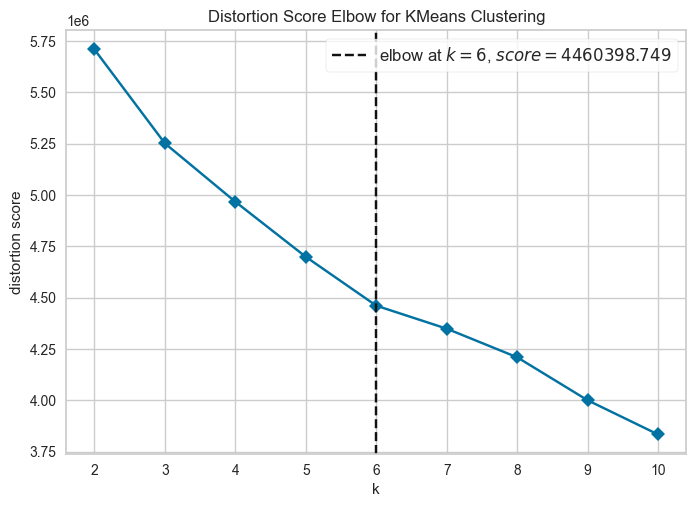

In [293]:
plot_model(kmeans, plot = 'elbow')

In [294]:
# plot_model(kmeans, plot = 'distribution')

In [295]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [296]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84116 entries, 0 to 84115
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            84116 non-null  object
 1   date_              84116 non-null  object
 2   send_count         84116 non-null  Int64 
 3   impressions_count  84116 non-null  Int64 
 4   read_count         84116 non-null  Int64 
 5   activated_count    84116 non-null  Int64 
 6   conveted_count     84116 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 4.9+ MB


In [297]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,conveted_count
count,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.0,0.889878,0.679585,0.411384,0.221313
std,0.0,0.313043,0.466639,0.492088,0.415134
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [298]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split(" ", expand=False).str[0],
        date_ = lambda x: x.index_.str.split(" ", expand=False).str[1]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [299]:
res.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1,is_act_m1,is_conv_m1,send_count,impressions_count,read_count,activated_count,conveted_count
count,77672.0,77672.0,83595.0,84009.0,62494.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.209924,1.836274,0.872669,0.451589,44.31507,0.064138,5.336305,0.800704,0.719316,0.584086,0.399068,0.228007,1.0,0.889878,0.679585,0.411384,0.221313
std,1.76174,1.841651,1.72637,1.857508,95.818135,0.244999,1.369059,0.399474,0.449336,0.492882,0.48971,0.419549,0.0,0.313043,0.466639,0.492088,0.415134
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,3.0,0.0,4.382027,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
50%,0.0,1.386294,0.0,0.0,13.0,0.0,5.863631,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
75%,2.302585,3.401197,0.693147,0.0,45.0,0.0,6.461468,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
max,8.2247,8.548886,9.481817,12.551437,2907.0,1.0,7.257708,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [303]:
res.groupby([ 'date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  M1_acc_count  \
date_      Cluster                                                 
2023-05-01 Cluster 0       0.882258       1.119071       0.29785   
           Cluster 1       2.735001        3.02258      0.521746   
           Cluster 2       5.773399       3.299182      0.222117   
           Cluster 3       0.008826       1.666673      1.576607   
2023-06-01 Cluster 0       0.701537       0.942559      0.329572   
           Cluster 1       2.734627        3.07164      0.546416   
           Cluster 2       5.431315       3.922301      0.211896   
           Cluster 3       0.012582       1.934428      2.346768   
2023-07-01 Cluster 0       0.555862       0.730096      0.310057   
           Cluster 1       2.776796       2.897455      0.537959   
           Cluster 2       5.515388       4.112105      0.317776   
           Cluster 3       0.074523       1.874898      1.749828   
2023-08-01 Cluster 0       0.874305       1.522591      0.284263   
           Cluster 1       2.584638       2.885096      0.561703   
           Cluster 2       5.526419       4.071418      0.304624   
           Cluster 3       0.016325       2.040818      1.772906   

                      M1_campaign_saldo  total_customer  is_referrer  \
date_      Cluster                                                     
2023-05-01 Cluster 0           0.099841       11.784241     0.028659   
           Cluster 1           1.128409       94.023533     0.116303   
           Cluster 2           3.917158      428.292359     0.413907   
           Cluster 3            0.22262        9.905564     0.033327   
2023-06-01 Cluster 0           0.042658       10.039276     0.027642   
           Cluster 1           0.439877       84.244643     0.122398   
           Cluster 2           1.301239      484.360465     0.385057   
           Cluster 3           0.000757        9.432753      0.01774   
2023-07-01 Cluster 0           0.171889         9.67594     0.039566   
           Cluster 1           1.913947       72.008801       0.1325   
           Cluster 2           6.260159       400.03861     0.320463   
           Cluster 3           0.023719        9.108108     0.036454   
2023-08-01 Cluster 0           0.092959       12.194228     0.043799   
           Cluster 1           0.861626       75.526008      0.13811   
           Cluster 2           3.911906      425.700555     0.327808   
           Cluster 3                0.0       10.033544     0.036446   

                      age_on_platform_days  is_send_m1  is_imp_m1  is_read_m1  \
date_      Cluster                                                              
2023-05-01 Cluster 0              4.759609    0.956278   0.864969     0.73807   
           Cluster 1              5.478912    0.885378   0.803361    0.688739   
           Cluster 2              6.253966    0.274834   0.261589    0.221854   
           Cluster 3               5.65936    0.786452    0.70585    0.580149   
2023-06-01 Cluster 0              4.802555    0.978588   0.879801    0.730373   
           Cluster 1               5.61329    0.835964   0.759094    0.661862   
           Cluster 2              5.994888    0.954023   0.925287    0.787356   
           Cluster 3              4.975978    0.386819   0.348266     0.28107   
2023-07-01 Cluster 0               5.20086    0.819182   0.722335    0.553457   
           Cluster 1              5.888016    0.672113   0.610875    0.509405   
           Cluster 2              6.202648    0.584942   0.542471     0.46332   
           Cluster 3              5.514801    0.789716   0.712011    0.531658   
2023-08-01 Cluster 0              5.068491    0.956998   0.863229      0.6956   
           Cluster 1              5.963678    0.969943   0.870133    0.707673   
           Cluster 2              6.261943    0.974217   0.882136    0.694291   
           Cluster 3              5.552502    0.780733   0.693262    0.531521   

                      is_act_m1  is_conv_

In [301]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  M1_core_count  M1_ppob_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0      7502          7502           7437           7437   
           Cluster 1      2975          2975           2975           2975   
           Cluster 2       302           302            302            302   
           Cluster 3      5521          5521           5293           5293   
2023-06-01 Cluster 0      8827          8827           8770           8770   
           Cluster 1      4371          4371           4371           4371   
           Cluster 2       174           174            174            174   
           Cluster 3     10090         10090           4463           4463   
2023-07-01 Cluster 0     12814         12814          12764          12764   
           Cluster 1      7283          7283           7283           7283   
           Cluster 2       518           518            518            518   
           Cluster 3      5212          5212           4991           4991   
2023-08-01 Cluster 0      5023          5023           5003           5003   
           Cluster 1      7885          7885           7885           7885   
           Cluster 2       543           543            543            543   
           Cluster 3      5076          5076           4900           4900   

                      M1_acc_count  M1_campaign_saldo  total_customer  \
date_      Cluster                                                      
2023-05-01 Cluster 0          7450               7500            5914   
           Cluster 1          2975               2975            2932   
           Cluster 2           302                302             301   
           Cluster 3          5443               5506            3918   
2023-06-01 Cluster 0          8789               8825            5805   
           Cluster 1          4371               4371            4247   
           Cluster 2           174                174             172   
           Cluster 3          9910              10047            3792   
2023-07-01 Cluster 0         12787              12796            6758   
           Cluster 1          7283               7283            7158   
           Cluster 2           518                518             518   
           Cluster 3          5136               5201            4292   
2023-08-01 Cluster 0          5009               5022            4366   
           Cluster 1          7885               7885            7517   
           Cluster 2           543                543             541   
           Cluster 3          5020               5061            4263   

                      is_referrer  acquisition_channel  \
date_      Cluster                                       
2023-05-01 Cluster 0         7502                 7502   
           Cluster 1         2975                 2975   
           Cluster 2          302                  302   
           Cluster 3         5521                 5521   
2023-06-01 Cluster 0         8827                 8827   
           Cluster 1         4371                 4371   
           Cluster 2          174                  174   
           Cluster 3        10090                10090   
2023-07-01 Cluster 0        12814                12814   
           Cluster 1         7283                 7283   
           Cluster 2          518                  518   
           Cluster 3         5212                 5212   
2023-08-01 Cluster 0         5023                 5023   
           Cluster 1         7885                 7885   
           Cluster 2          543                  543   
           Cluster 3         5076                 5076   

                      user_segment_sub_bucket  ...  is_imp_m1  is_read_m1  \
date_      Cluster                             ...                          
2023-05-01 Cluster 0                     7502  ...       7502        7502   
           Cluster 1      